In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import matplotlib.pyplot as plt

In [2]:
seed = 8
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

epochs = 20
test_batch_size = 10
train_batch_size = 64
learning_rate = 0.001

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="./torch_datasets", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root="./torch_datasets", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

Extracting ./torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_datasets/MNIST/raw


Extracting ./torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_datasets/MNIST/raw


Extracting ./torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_datasets/MNIST/raw


Extracting ./torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_datasets/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, image_size):
        super(Autoencoder, self).__init__()
        self.image_size = image_size
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.image_size, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.image_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(image_size=784).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
train_loss_list = []

In [6]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = loss_function(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()

    loss = loss / len(train_loader)
    train_loss_list.append(loss)
    print("epoch : {}/{}, train loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, train loss = 0.03556359
epoch : 2/20, train loss = 0.02095591
epoch : 3/20, train loss = 0.01815980
epoch : 4/20, train loss = 0.01666072
epoch : 5/20, train loss = 0.01565993
epoch : 6/20, train loss = 0.01504042
epoch : 7/20, train loss = 0.01458324
epoch : 8/20, train loss = 0.01422771
epoch : 9/20, train loss = 0.01359699
epoch : 10/20, train loss = 0.01318479
epoch : 11/20, train loss = 0.01295795
epoch : 12/20, train loss = 0.01270989
epoch : 13/20, train loss = 0.01254230
epoch : 14/20, train loss = 0.01234233
epoch : 15/20, train loss = 0.01219754
epoch : 16/20, train loss = 0.01208734
epoch : 17/20, train loss = 0.01196299
epoch : 18/20, train loss = 0.01186085
epoch : 19/20, train loss = 0.01177976
epoch : 20/20, train loss = 0.01170193


In [7]:
def predict_test_examples():
    test_examples = None
    reconstruction = None
    with torch.no_grad():
        for batch_features in test_loader:
            batch_features = batch_features[0]
            test_examples = batch_features.view(-1, 784).to(device)
            reconstruction = model(test_examples)
            break
    return test_examples, reconstruction


def display_loss_graph():
    plt.figure()
    plt.plot(train_loss_list)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.savefig('deep_ae_fashionmnist_loss.png')


def output_test_examples():
    with torch.no_grad():
        number = 10
        plt.figure(figsize=(20, 4))
        for index in range(number):
            # display original
            ax = plt.subplot(2, number, index + 1)
            plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, number, index + 1 + number)
            plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

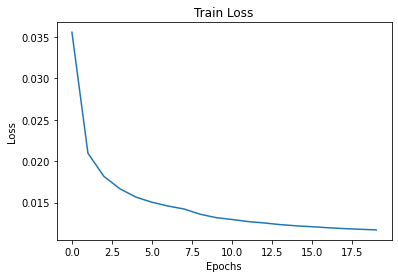

<Figure size 432x288 with 0 Axes>

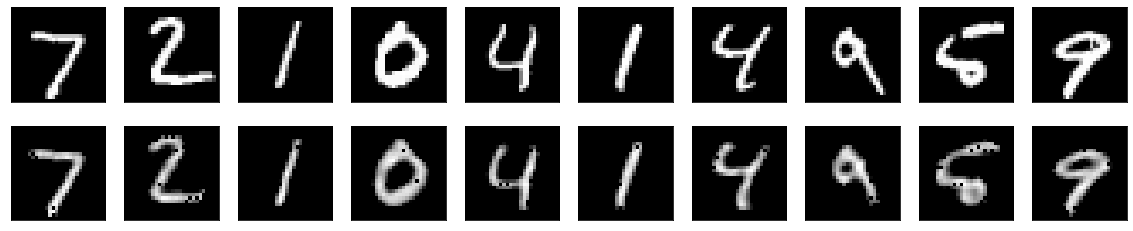

In [8]:
display_loss_graph()
test_examples, reconstruction = predict_test_examples()
output_test_examples()